In [1]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# --- origin and destination geom

# origin_geom =  Point(6.85724739546158, 79.87442395196082)
# destination_geom = Point(6.913559346130495, 79.86105201274425)
origin_geom =  Point(79.8612, 6.9271)
destination_geom = Point(80.6337, 7.2906)

# --- create origin dataframe

origin =  gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
origin.at[0, 'name'] = 'origin'
origin.at[0, 'geometry'] =origin_geom

# --- create destination dataframe

destination =  gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
destination.at[0, 'name'] = 'destination'
destination.at[0, 'geometry'] = destination_geom

In [3]:
def get_graph_from_locations(origin, destination, network='drive'):
    '''
    network_type as drive, walk, bike
    origin gdf 5234
    destination gdf 5234
    '''
    # combine and area buffer
    combined = pd.concat([origin, destination])

    convex = combined.unary_union.envelope # using envelope instead of convex, otherwise it breaks the unary_union
    
    graph_extent = convex.buffer(0.02)

    graph = ox.graph_from_polygon(graph_extent, network_type= network)

    return graph

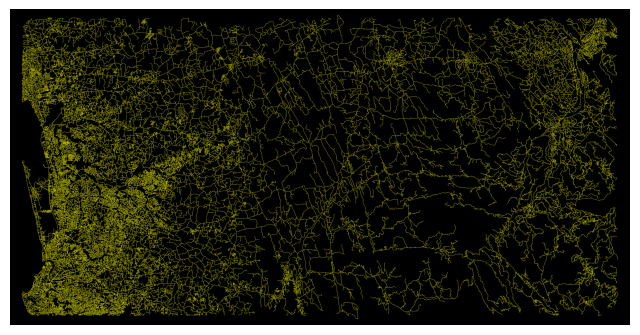

In [4]:
# --- Get Graph
graph = get_graph_from_locations(origin, destination)
fig, ax = ox.plot_graph(graph, node_size=0, edge_linewidth=0.4, bgcolor='black', edge_alpha=0.2,  edge_color='yellow')

In [5]:
# --- add edge speed
graph = ox.add_edge_speeds(graph)

# --- add travel time
graph = ox.add_edge_travel_times(graph)

In [6]:
# --- add speeds define by local authorities (example)
hwy_speeds = {"residential": 35, "secondary": 60, "tertiary": 75}

graph = ox.add_edge_speeds(graph, hwy_speeds)
graph = ox.add_edge_travel_times(graph)

In [7]:
# --- get the edges as GDF
edges = ox.graph_to_gdfs(graph, nodes=False)[['highway', 'speed_kph', 'length', 'travel_time', 'geometry']].reset_index(drop=True)

# --- see mean speed/time values by road type
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["speed_kph", "travel_time"]].mean().round(0)

,speed_kph,travel_time
highway,,
"['motorway', 'secondary']",50.0,71.0
"['primary_link', 'primary']",60.0,10.0
"['residential', 'living_street']",31.0,30.0
"['residential', 'motorway']",30.0,23.0
"['residential', 'road']",32.0,37.0
"['residential', 'tertiary']",35.0,68.0
"['tertiary', 'secondary']",50.0,396.0
"['unclassified', 'living_street']",26.0,57.0
"['unclassified', 'residential', 'living_street']",30.0,61.0


In [8]:
# ------------- get closest nodes

# origin
closest_origin_node = ox.nearest_nodes(G=graph, 
                                       X=origin_geom.x, 
                                       Y=origin_geom.y)

# destination
closest_destination_node = ox.nearest_nodes(G=graph, 
                                           X=destination_geom.x, 
                                           Y=destination_geom.y)

In [9]:
# --- calculate shortest path with length and travel time

# time
fastest_route = ox.shortest_path(graph, 
                                orig = closest_origin_node, 
                                dest = closest_destination_node, 
                                weight="travel_time")

In [10]:
# distance
shortest_route = ox.shortest_path(graph, 
                                orig = closest_origin_node, 
                                dest = closest_destination_node,  
                                weight="length")

In [11]:
# --- get gdf of routes

# fastest
fastest_route_gdf = ox.utils_graph.route_to_gdf(graph, fastest_route, weight='travel_time')[['highway', 'speed_kph', 'travel_time', 'geometry','length']]

# shortest
shortest_route_gdf = ox.utils_graph.route_to_gdf(graph, shortest_route, weight='length')[['highway', 'speed_kph', 'travel_time', 'geometry','length']]

In [12]:
# print(fastest_route_gdf.columns)

In [13]:
# --- comparison

d1 = fastest_route_gdf['length'].sum()
d2 = shortest_route_gdf['length'].sum()

t1 = fastest_route_gdf['travel_time'].sum()
t2 = shortest_route_gdf['travel_time'].sum()

In [14]:
print(f'Fastest Route: Time {round(t1/3600, 2)} hours, Distance {round(d1/1000, 2)} km')
print(f'Shortest Route: Time {round(t2/3600, 2)} hours, Distance {round(d2/1000, 2)} km')

Fastest Route: Time 1.81 hours, Distance 114.37 km
Shortest Route: Time 1.9 hours, Distance 113.43 km


In [15]:
# --- save

edges.to_file('osm_drive_network.gpkg')

fastest_route_gdf.to_file('fastest_route.gpkg')

shortest_route_gdf.to_file('shortest_route.gpkg')

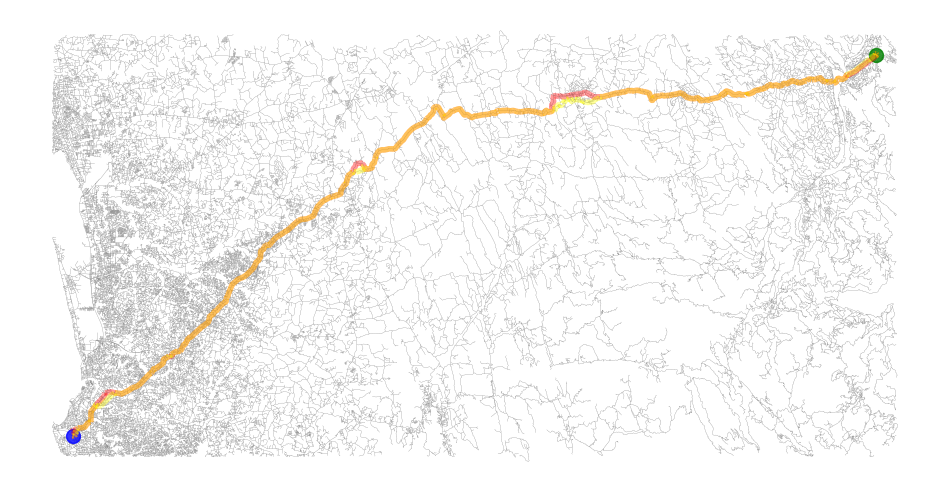

In [16]:
# --- plot network
ax = edges.plot(figsize=(12, 10), linewidth = 0.1, color='grey', zorder=0);

# --- origin and destination
origin.plot(ax=ax, markersize=100, alpha=0.8, color='blue', zorder=1)
destination.plot(ax=ax, markersize=100, alpha=0.8, color='green', zorder=2)

# --- route
fastest_route_gdf.plot(ax=ax, linewidth = 4, color='red', alpha=0.4, zorder=3)
shortest_route_gdf.plot(ax=ax, linewidth = 4, color='yellow', alpha=0.4, zorder=4)

plt.axis(False);